### Generate spectrogrrams

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm
from joblib import Parallel, delayed

PATH_TO_BIRDCLEF = "birdclef-2022"

meta = pd.read_csv(f"{PATH_TO_BIRDCLEF}/train_metadata.csv")

base_path = f"{PATH_TO_BIRDCLEF}/train_audio/"
audio_name = f"{PATH_TO_BIRDCLEF}/train_audio/afrsil1/XC125458.ogg"
image_directory = f"{PATH_TO_BIRDCLEF}/train_images/"
hop_length = 512
window_size = 1024


### Example for first testfile

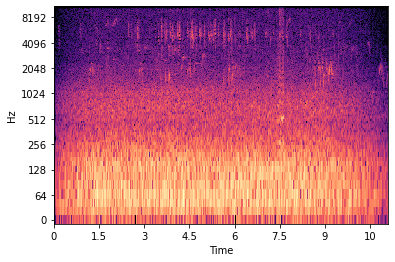

In [4]:
y, sr = librosa.load(audio_name)
window = np.hanning(window_size)
out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length,
       window=window)
out = 2 * np.abs(out) / np.sum(window)

librosa.display.specshow(librosa.amplitude_to_db(out,ref=np.max),
               y_axis='log', x_axis='time')

In [5]:
import skimage.io

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(image_directory + out + '.png', img)

def spectrogram_image(y, sr, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    return img

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def load_batch_spectograms(audio_names):
    for entry in audio_names:
        y, sr = librosa.load(base_path + entry)
        spectrogram_image(y, sr, entry[:-4], hop_length, 256)

#### Convert to Mel-Spectrogram

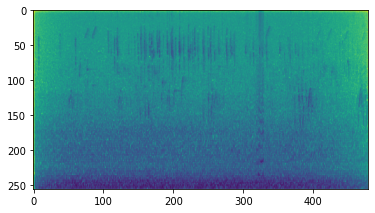

In [6]:
spec = spectrogram_image(y, sr, hop_length, 256)
plt.imshow(spec)

### Persist Spectorgrams

In [7]:
# careful, this takes multiple hours to run

def generate_spectograms():

    names = meta['filename']
    load_batch_spectograms(names)


In [8]:
import os
def add_folder_structure():
    names = meta['primary_label'].unique()
    for name in names:
        os.mkdir(image_directory + name)

### Split Mel-Specs to 5 second clips

Logic: 30 sec / 5 sec => 6 files with 5 secs

In [9]:
def save_spectro(in_spectro, filepath):
    pass

### Main Loop

1. Metadata.csv einlesen und die Spalte der Pfade + Primary_Label holen
2. Für jedes Audio-File Spectrogram erstellen
    1. Spectrogramm in 5 secs aufteilen
    2. Einzelteile aufspalten
   

In [10]:
import pandas as pd
import math
PATH_TO_BIRDCLEF = "birdclef-2022"
PATH_TO_SPECTRO = f"{PATH_TO_BIRDCLEF}/train_spectro"
DURATION = 5

metadata_df = pd.read_csv(f"{PATH_TO_BIRDCLEF}/train_metadata.csv")
train_df = metadata_df[['primary_label', 'filename']]

class AudioParams:
    sr = 32000
    duration = 5
    n_mels = 224
    fmin = 20
    fmax = 16000

   

### Helper Functions
Source: https://www.kaggle.com/code/kaerunantoka/birdclef2022-create-image-data-from-audio-data

In [11]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec


def crop_or_pad(y, length, sr, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if probs is None:
            start = np.random.randint(len(y) - length)
        else:
            start = (
                    np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start: start + length]

    return y.astype(np.float32)

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def spectrogram_image(y, sr, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    return img

In [12]:
def generate_spectrograms(y):
    # 5 * 32000 = 160000, sr = sampling rate
    spec = crop_or_pad(y, AudioParams.duration * AudioParams.sr, sr=AudioParams.sr, probs=None)
    spec = spectrogram_image(spec, sr, hop_length, 256)
    return spec


Test ohne Splits

244800
256


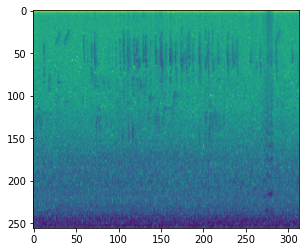

In [13]:
# Import test data
y, sr = librosa.load(audio_name)
# for splice in generate_split_spectrograms(y):
#     plt.imshow(splice)
print(len(y))
plt.imshow(generate_spectrograms(y))
y = generate_spectrograms(y)

print(len(y))

Test mit Splits

In [14]:
def slice_spectrogram(y, duration, sr):
    slices = []

    # 5 Seconds = 5 * Abtastrate(sr)
    slice_duration = duration * sr
    y_length = len(y)

    # Iterate over y duration enough times to fit to duration
    for i in range(0, math.ceil((len(y)/slice_duration))):

        # Fill slice shorter than duration with zeros to match the duration
        if y_length <= slice_duration:
            #print(f"{i}. if: y_length leftover: {y_length}")
            #print(f"{i}. from: {len(y) - y_length}, to: {len(y)}")
            #print(f"Appending zeros to fit {slice_duration} is {slice_duration - y_length}")

            end_piece = np.concatenate([y[(len(y) - y_length):len(y)], np.zeros(slice_duration - y_length)])
            end_piece = end_piece.astype(np.float32)
            slices.append(end_piece)
        else:
            #print(f"{i}. from: {i*slice_duration} to {(i+1)*slice_duration}")
            #print(f"{i}. else: old:{y_length} new:{y_length-slice_duration}")
            
            piece = y[(i*slice_duration):((i+1)*slice_duration)]
            piece = piece.astype(np.float32)
            slices.append(piece)
            y_length -= slice_duration
    return slices

def generate_split_spectrograms(y, duration, sr):
    spec_splices = slice_spectrogram(y=y, duration=duration, sr=sr)
    splices = []
    for spec in spec_splices:
        #print(f"Finale Länge der specs: {len(spec)}")
        spec = spectrogram_image(spec, sr, hop_length, 256)
        spec = mono_to_color(spec)
        splices.append(spec)
    return splices

244800


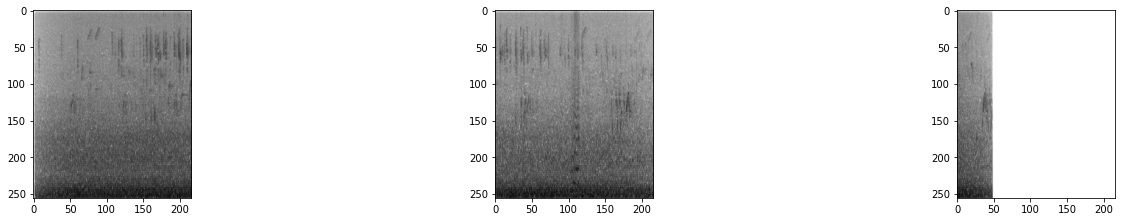

In [15]:
# Import test data

y, sr = librosa.load(audio_name)
print(len(y))

results = generate_split_spectrograms(y, DURATION, sr)

plt.figure(figsize=(40,20))

for i, element in enumerate(results):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(element)
plt.show()

### Summary

In [16]:
def generate_split_spectorgrams_loop(train_df):
    print(len(train_df['filename']))
    for index, file in enumerate(train_df['filename']):
        print(index)
        path = f"{PATH_TO_BIRDCLEF}/train_audio/{file}"
        y, sr = librosa.load(path)

        results = generate_split_spectrograms(y, DURATION, sr)
        counter = 0
        for result in results:
            output = file.split("/")[-1][:-4]
            dir_name = f"{PATH_TO_SPECTRO}/{train_df['primary_label'][index]}"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)

            np.save(f"{dir_name}/{output}_{counter}", result)
            #skimage.io.imsave(f"{dir_name}/{output}_{counter}.png", result)
            counter += 1  

(256, 216, 3)


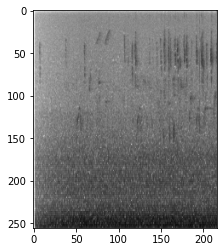

In [17]:
x = np.load("G:/Hochschule/birdclef2022/birdclef-2022/train_spectro/afrsil1/XC125458_0.npy")
print(x.shape)
plt.imshow(x)

In [18]:
train_df.head()

,primary_label,filename
0,afrsil1,afrsil1/XC125458.ogg
1,afrsil1,afrsil1/XC175522.ogg
2,afrsil1,afrsil1/XC177993.ogg
3,afrsil1,afrsil1/XC205893.ogg
4,afrsil1,afrsil1/XC207431.ogg


In [19]:
len(train_df['filename'])

14852

In [20]:
train_df["primary_label"].unique()

array(['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'amewig',
       'aniani', 'apapan', 'arcter', 'barpet', 'bcnher', 'belkin1',
       'bkbplo', 'bknsti', 'bkwpet', 'blkfra', 'blknod', 'bongul',
       'brant', 'brnboo', 'brnnod', 'brnowl', 'brtcur', 'bubsan',
       'buffle', 'bulpet', 'burpar', 'buwtea', 'cacgoo1', 'calqua',
       'cangoo', 'canvas', 'caster1', 'categr', 'chbsan', 'chemun',
       'chukar', 'cintea', 'comgal1', 'commyn', 'compea', 'comsan',
       'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra',
       'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea',
       'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo',
       'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1',
       'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb',
       'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow',
       'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo

In [21]:
skip_list = ['comsan',
       'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra',
       'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea',
       'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo',
       'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1',
       'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb',
       'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow',
       'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo', 'mauala',
       'maupar', 'merlin', 'mitpar', 'moudov', 'norcar', 'norhar2',
       'normoc', 'norpin', 'norsho', 'nutman', 'oahama', 'omao', 'osprey',
       'pagplo', 'palila', 'parjae', 'pecsan', 'peflov', 'perfal',
       'pibgre', 'pomjae', 'puaioh', 'reccar', 'redava', 'redjun',
       'redpha1', 'refboo', 'rempar', 'rettro', 'ribgul', 'rinduc',
       'rinphe', 'rocpig', 'rorpar', 'rudtur', 'ruff', 'saffin', 'sander',
       'semplo', 'sheowl', 'shtsan', 'skylar', 'snogoo', 'sooshe',
       'sooter1', 'sopsku1', 'sora', 'spodov', 'sposan', 'towsol',
       'wantat1', 'warwhe1', 'wesmea', 'wessan', 'wetshe', 'whfibi',
       'whiter', 'whttro', 'wiltur', 'yebcar', 'yefcan', 'zebdov']

skip_df = train_df.loc[train_df['primary_label'].isin(skip_list)]
skip_df = skip_df.reset_index()


In [22]:
#generate_split_spectorgrams_loop(skip_df)

Generate Splits

In [23]:
#Takes a while
#generate_split_spectorgrams_loop(train_df)

## Count Trainingsdata Splits


<AxesSubplot:>

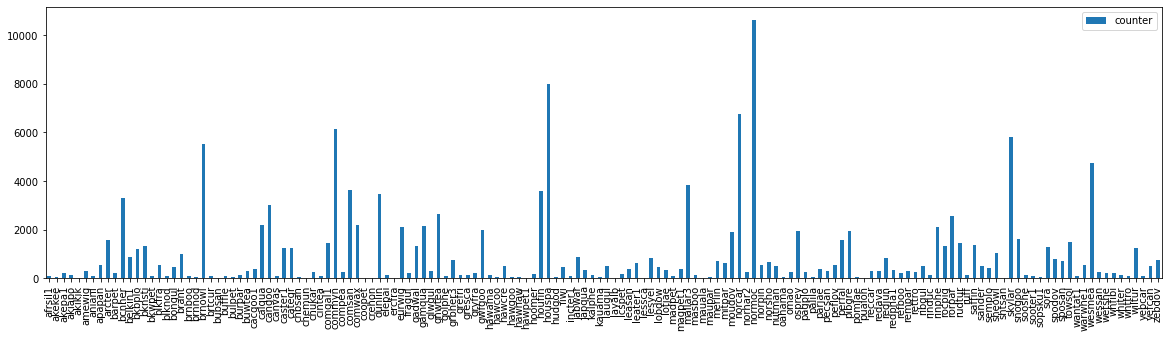

In [24]:
import os, os.path

split_count_dict = {}

for primary_label in os.listdir(PATH_TO_SPECTRO):
    counter = 0
    for spectro_split in os.listdir(f"{PATH_TO_SPECTRO}/{primary_label}"):
        counter += 1
    split_count_dict[primary_label] = counter

count_df = pd.DataFrame.from_dict(data=split_count_dict, columns=['counter'], orient='index')

count_df.plot(kind='bar', figsize=(20,5))
